<a href="https://colab.research.google.com/github/aliceai0810/capstoneA7/blob/main/A7_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Analysis

### Data Preperation

In [1]:
! pip install spacytextblob
! pip install afinn
! pip install emoji
! pip install nltk
! pip install scikit-plot
! pip install tokenwiser
! pip install -U spacy
! pip install wordcloud
! pip install umap-learn

     |████████████████████████████████| 6.0 MB 11.3 MB/s 
     |████████████████████████████████| 451 kB 65.5 MB/s 
     |████████████████████████████████| 42 kB 994 kB/s 
     |████████████████████████████████| 181 kB 81.6 MB/s 
     |████████████████████████████████| 10.1 MB 12.7 MB/s 
     |████████████████████████████████| 628 kB 68.0 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 52 kB

In [2]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from urllib.request import urlopen
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import scikitplot as skplot
from wordcloud import WordCloud
import emoji
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer  
import nltk
from tokenwiser.textprep import HyphenTextPrep
from nltk.corpus import stopwords
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy import cli
from afinn import Afinn
from nltk.tokenize import word_tokenize, RegexpTokenizer, WordPunctTokenizer, TweetTokenizer
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import accuracy_score
import srsly
import typer
import warnings
from pathlib import Path
from spacy.tokens import DocBin
from sklearn.metrics import adjusted_rand_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')
reviews = pd.read_csv('/content/drive/Shareddrives/BA820-A7/Data/olist_order_reviews_dataset_en.csv')

Mounted at /content/drive


In [4]:
def remove_punct(text):
  import string
  text = ''.join([p for p in text if p not in set(string.punctuation)])
  return text

In [5]:
reviewsdf = reviews.loc[reviews.review_comment_message_en.isna()==False,['review_score','review_comment_message_en']].reset_index().drop(['index'],axis=1)
reviewsdf.loc[(reviewsdf.review_score==5)|(reviewsdf.review_score==4),'review_score']='satisfied'
reviewsdf.loc[(reviewsdf.review_score==1)|(reviewsdf.review_score==2),'review_score']='unsatisfied'
reviewsdf.loc[reviewsdf.review_score==3,'review_score']='neutral'
reviewsdf.review_comment_message_en = reviewsdf.review_comment_message_en.str.lower()
reviewsdf.review_comment_message_en = reviewsdf.review_comment_message_en.apply(remove_punct)

### Word Cloud

Customer reviews are mainly about the product and their deliveries.

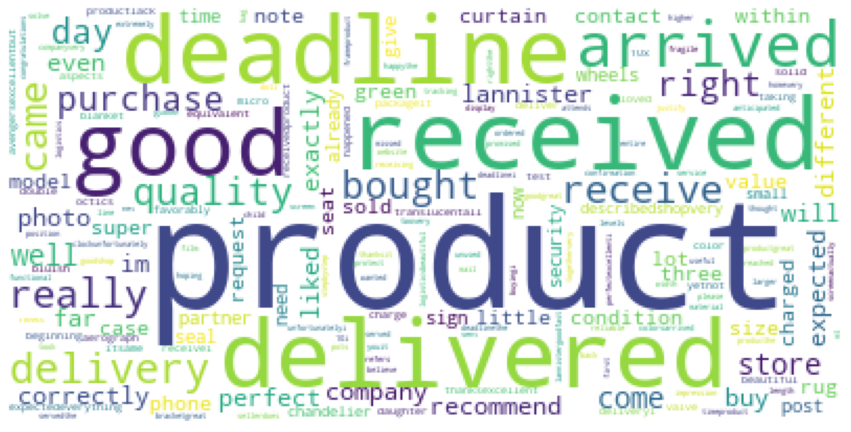

In [6]:
record = ''
for i in reviewsdf.sample(100).review_comment_message_en:
    record+=i
wc = WordCloud(background_color='white')
wordcloud = wc.generate(record)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

### Countvectorizer + Decision Tree

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00      1067
   satisfied       0.81      0.94      0.87      7957
 unsatisfied       0.72      0.66      0.69      3267

    accuracy                           0.78     12291
   macro avg       0.51      0.53      0.52     12291
weighted avg       0.71      0.78      0.74     12291



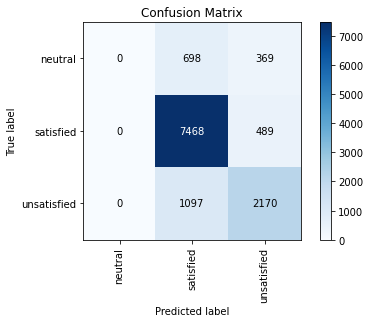

0.7841510048002603

In [7]:
cv = CountVectorizer()
dtm = cv.fit_transform(reviewsdf.review_comment_message_en)
dtm_df = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())
X = dtm_df.copy()
y = reviewsdf.review_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=820, stratify=y)
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=30, min_samples_leaf=15)
tree.fit(X_train, y_train)
preds = tree.predict(X_test)
ctable = metrics.classification_report(y_test, preds)
print(ctable)
skplot.metrics.plot_confusion_matrix(y_test, preds, 
                                     figsize=(7,4), 
                                     x_tick_rotation=90 )
plt.show()
tree.score(X_test, y_test)

### Afinn Score

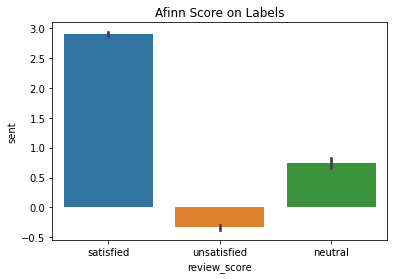

In [8]:
afinn = Afinn()
def sentiment(text):
    return afinn.score(text)
reviewsdf['sent'] = reviewsdf.review_comment_message_en.apply(sentiment)
reviewsdf.sent.describe()
sns.barplot(x=reviewsdf.review_score,y=reviewsdf.sent)
plt.title('Afinn Score on Labels');

In [9]:
cli.download("en_core_web_sm")

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Polarity and Subjectivity Score

In [10]:
def polarity(a):
    return nlp(a)._.polarity
def subjectivity(a):
    return nlp(a)._.subjectivity

In [11]:
reviewsdf['polarity']=reviewsdf.review_comment_message_en.apply(polarity)
reviewsdf['subjectivity']=reviewsdf.review_comment_message_en.apply(subjectivity)

In [12]:
reviewsdf.head()

,review_score,review_comment_message_en,sent,polarity,subjectivity
0,satisfied,i received well before the stipulated deadline,0.0,0.000000,0.000000
1,satisfied,congratulations lannister stores i loved to bu...,11.0,0.666667,0.766667
2,satisfied,efficient device on the site the mark of the d...,0.0,0.000000,0.125000
3,satisfied,but a little catching for the value is good\n,3.0,0.370833,0.666667
4,satisfied,reliable seller product ok and delivery before...,2.0,0.500000,0.500000


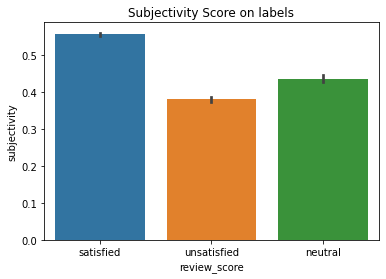

In [13]:
sns.barplot(x = 'review_score', y = 'subjectivity',data = reviewsdf)
plt.title('Subjectivity Score on labels')
plt.show()

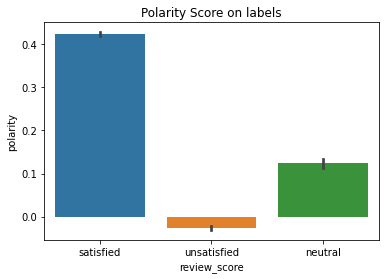

In [14]:
sns.barplot(x = 'review_score', y = 'polarity',data = reviewsdf)
plt.title('Polarity Score on labels')
plt.show()

Although afinn, polarity and subjectivity scores generally align with the labels, when take a closer look at the incorrect labels, the models was not able to understand the meaning of the text. 

### Named Entity Recognition

In [15]:
! git clone https://github.com/Btibert3/BA820-Fall-2021.git

Cloning into 'BA820-Fall-2021'...
remote: Enumerating objects: 739, done.
remote: Counting objects: 100% (739/739), done.
remote: Compressing objects: 100% (565/565), done.
remote: Total 739 (delta 349), reused 501 (delta 139), pack-reused 0
Receiving objects: 100% (739/739), 18.65 MiB | 15.55 MiB/s, done.
Resolving deltas: 100% (349/349), done.


In [16]:
def customer_messages():
    """Generate a csv of messages to use for custom NER tasks

    Args:
        topic (str, optional): The topic to use in the WHERE clause. Defaults to "Shipping".
        project (str, optional): Billing project for Google Cloud. Defaults to "questrom".
    """
    
    df = reviewsdf
    # write to csv
    df = df.sample(100, random_state=820)
    df.review_comment_message_en.to_csv("messages.csv", index=False)


if __name__ == "__main__":
    # TODO: cli args via click or some other tool
    customer_messages()

In [17]:
path = '/content/drive/Shareddrives/BA820-A7/custom_labels.json'
with open(path, 'r') as f:
  a = json.load(f)

In [18]:
TRAIN_DATA = []
for entry in a:
  doc = entry.get('data').get('review_comment_message_en')
  result = entry.get("annotations")[0].get('result')
  if len(result) == 0:
    continue
  entities = []
  for r in result:
    ent = r.get('value')
    entities.append([ent.get('start'), ent.get('end'), ent.get('labels')[0]])
  TRAIN_DATA.append([doc, {'entities': entities}])


In [19]:
import srsly
import typer
import warnings
from pathlib import Path

import spacy
from spacy.tokens import DocBin

def convert(lang: str, TRAIN_DATA, output_path: Path):
    nlp = spacy.blank(lang)
    db = DocBin()
    for text, annot in TRAIN_DATA:
      doc = nlp.make_doc(text)
      ents = []
      for start, end, label in annot["entities"]:
        # print(start, end, label)
        span = doc.char_span(start, end, label=label)
        if span is None:
            msg = f"Skipping entity [{start}, {end}, {label}] in the following text because the character span '{doc.text[start:end]}' does not align with token boundaries:\n\n{repr(text)}\n"
            #warnings.warn(msg)
        else:
            ents.append(span)
      doc.ents = ents
      db.add(doc)
    db.to_disk(output_path)

# this wrties the file to our session standard working directory
convert("en", TRAIN_DATA, "train.spacy")

In [20]:
! python -m spacy init config --lang en --pipeline ner config.cfg --force
! cp train.spacy dev.spacy
! python -m spacy train config.cfg                     \
                        --output ./                    \
                        --paths.train ./train.spacy    \
                        --paths.dev ./dev.spacy        \
                        --training.max_epochs 5        \
                        --training.eval_frequency 10

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy
ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2021-12-08 17:01:17,290] [INFO] Set up nlp object from config
[2021-12-08 17:01:17,303] [INFO] Pipeline: ['tok2vec', 'ner']
[2021-12-08 17:01:17,308] [INFO] Created vocabulary
[2021-12-08 17:01:17,309] [INFO] Finished initializing nlp object
[2021-12-08 17:01:17,638] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pip

In [21]:
custom_nlp = spacy.load("model-best")
custom_nlp.pipe_names

['tok2vec', 'ner']

In [22]:
def extract(a):
    result = [ent.label_ for ent in custom_nlp(a).ents]
    sum = 0
    for i in result:
        if i=='positive':
            sum+=1
        elif i=='negative':
            sum-=1
    if sum==0:
        return 'neutral'
    elif sum>0:
        return 'satisfied'
    else:
        return 'unsatisfied'

In [23]:
X_test_cp = []
for i in X_test.index:
    X_test_cp.append(reviewsdf.loc[reviewsdf.index==i,'review_comment_message_en'].values[0])
X_test_cp = pd.Series(X_test_cp)

In [24]:
y_custom = X_test_cp.apply(extract)
ctable = metrics.classification_report(y_test, y_custom)
print(ctable)
print(round(accuracy_score(y_test,y_custom),2))

              precision    recall  f1-score   support

     neutral       0.12      0.26      0.17      1067
   satisfied       0.68      0.86      0.76      7957
 unsatisfied       0.83      0.00      0.00      3267

    accuracy                           0.58     12291
   macro avg       0.55      0.37      0.31     12291
weighted avg       0.67      0.58      0.51     12291

0.58
